In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


In [24]:
# Load and clean up the data
def load_data(file_path):
    df = pd.read_csv(file_path)
    df_clean = df.dropna()  # get rid of any missing data
    
    # Remove customer_id since it doesn't help with clustering
    df_clean = df_clean.drop(columns=['customer_id'])

    return df_clean

In [25]:
# Feature selection - drop features that dont really help with clustering
def select_features(df):
    df = df.drop(columns=['total_purchases','discount_counts','product_click'])
    return df

In [26]:
# Correlation matrix to see how features relate to each other
def show_corr_matrix(data):
    plt.figure(figsize=(8, 6))
    sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Between Features")
    plt.show()

In [27]:
# Distribution plots - gives an idea of how data is spread
def plot_distributions(data):
    for col in data.columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(data[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()

In [28]:
# Box plots - helps in finding outliers
def plot_box_plots(data):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data)
    plt.title("Box Plot of Features")
    plt.show()

In [29]:
# KDE plots - shows density of values
def plot_kde(data):
    plt.figure(figsize=(8, 5))
    for col in data.columns:
        sns.kdeplot(data[col], label=col)
    plt.title("Density of Features")
    plt.legend()
    plt.show()

In [30]:
# Pairplot - to see how features interact with each other
def plot_pairwise(data):
    sns.pairplot(data)
    plt.show()

In [31]:
# Skewness and kurtosis - tells how balanced or heavy-tailed the data is
def check_skew_kurt(data):
    print("\nSkewness:\n", data.skew())
    print("\nKurtosis:\n", data.kurtosis())

In [32]:
# Missing value heatmap - helps identify missing patterns (if any)
def plot_missing(data):
    plt.figure(figsize=(6, 4))
    sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Data Heatmap')
    plt.show()

In [33]:
# Scale data - makes clustering more accurate
def scale_data(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data

In [34]:
# Elbow method - helps decide how many clusters to use
def find_best_clusters(scaled_data):
    inertia = []
    K = range(1, 11)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_data)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(K, inertia, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method - Finding Optimal Clusters')
    plt.show()

In [35]:
# Compare KMeans and GMM
def compare_clustering(scaled_data):
    # KMeans clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans_labels = kmeans.fit_predict(scaled_data)

    # Gaussian Mixture Model
    gmm = GaussianMixture(n_components=3, random_state=42)
    gmm_labels = gmm.fit_predict(scaled_data)

    # Get scores for both models
    silhouette_kmeans = silhouette_score(scaled_data, kmeans_labels)
    silhouette_gmm = silhouette_score(scaled_data, gmm_labels)

    ch_kmeans = calinski_harabasz_score(scaled_data, kmeans_labels)
    ch_gmm = calinski_harabasz_score(scaled_data, gmm_labels)

    dbi_kmeans = davies_bouldin_score(scaled_data, kmeans_labels)
    dbi_gmm = davies_bouldin_score(scaled_data, gmm_labels)

    # Print Results
    print(f"{'Model':<20}{'Silhouette':<15}{'CH Index':<15}{'DBI'}")
    print('-' * 50)
    print(f"{'KMeans':<20}{silhouette_kmeans:<15.3f}{ch_kmeans:<15.3f}{dbi_kmeans:.3f}")
    print(f"{'GMM':<20}{silhouette_gmm:<15.3f}{ch_gmm:<15.3f}{dbi_gmm:.3f}")


In [36]:
# Create clusters using KMeans
def make_clusters(data, scaled_data, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    data['Cluster'] = clusters
    
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(scaled_data)
    data['PCA1'] = pca_data[:, 0]
    data['PCA2'] = pca_data[:, 1]
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
    plt.title('Clustered Data (PCA)')
    plt.show()

    return kmeans, clusters

In [37]:
# Label clusters based on behavior patterns
def label_clusters(data):
    cluster_map = {
        data.groupby('Cluster')['total_time_spent'].mean().idxmax(): 'Window Shoppers',
        data.groupby('Cluster')['avg_cart_value'].mean().idxmax(): 'High Spenders',
        data.groupby('Cluster')['total_time_spent'].mean().idxmin(): 'Bargain Hunters'
    }

    data['Segment'] = data['Cluster'].map(cluster_map)
    print(data.groupby('Segment').mean())

In [38]:
# Evaluate clustering performance
def evaluate_clusters(scaled_data, clusters, kmeans):
    silhouette = silhouette_score(scaled_data, clusters)
    davies_bouldin = davies_bouldin_score(scaled_data, clusters)
    rmse = np.sqrt(np.mean(np.linalg.norm(scaled_data - kmeans.cluster_centers_[clusters], axis=1) ** 2))

    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies-Bouldin Index: {davies_bouldin:.3f}')
    print(f'RMSE: {rmse:.3f}')

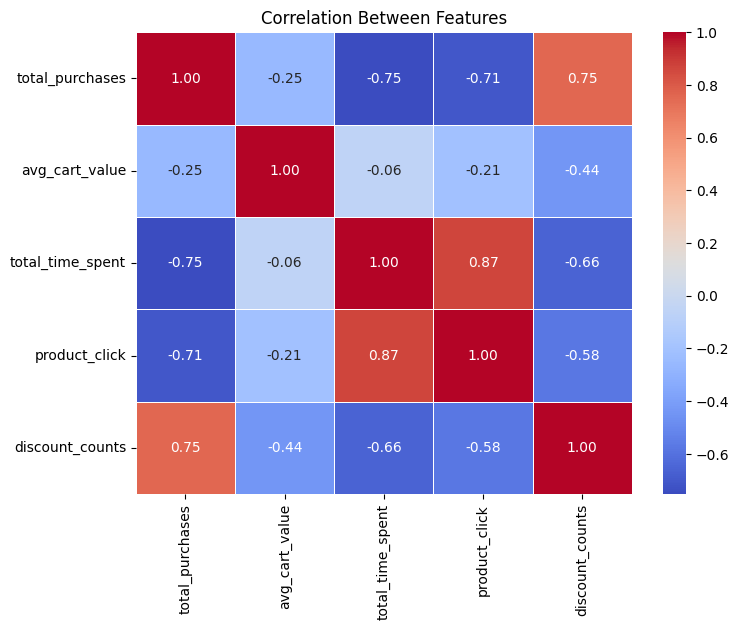

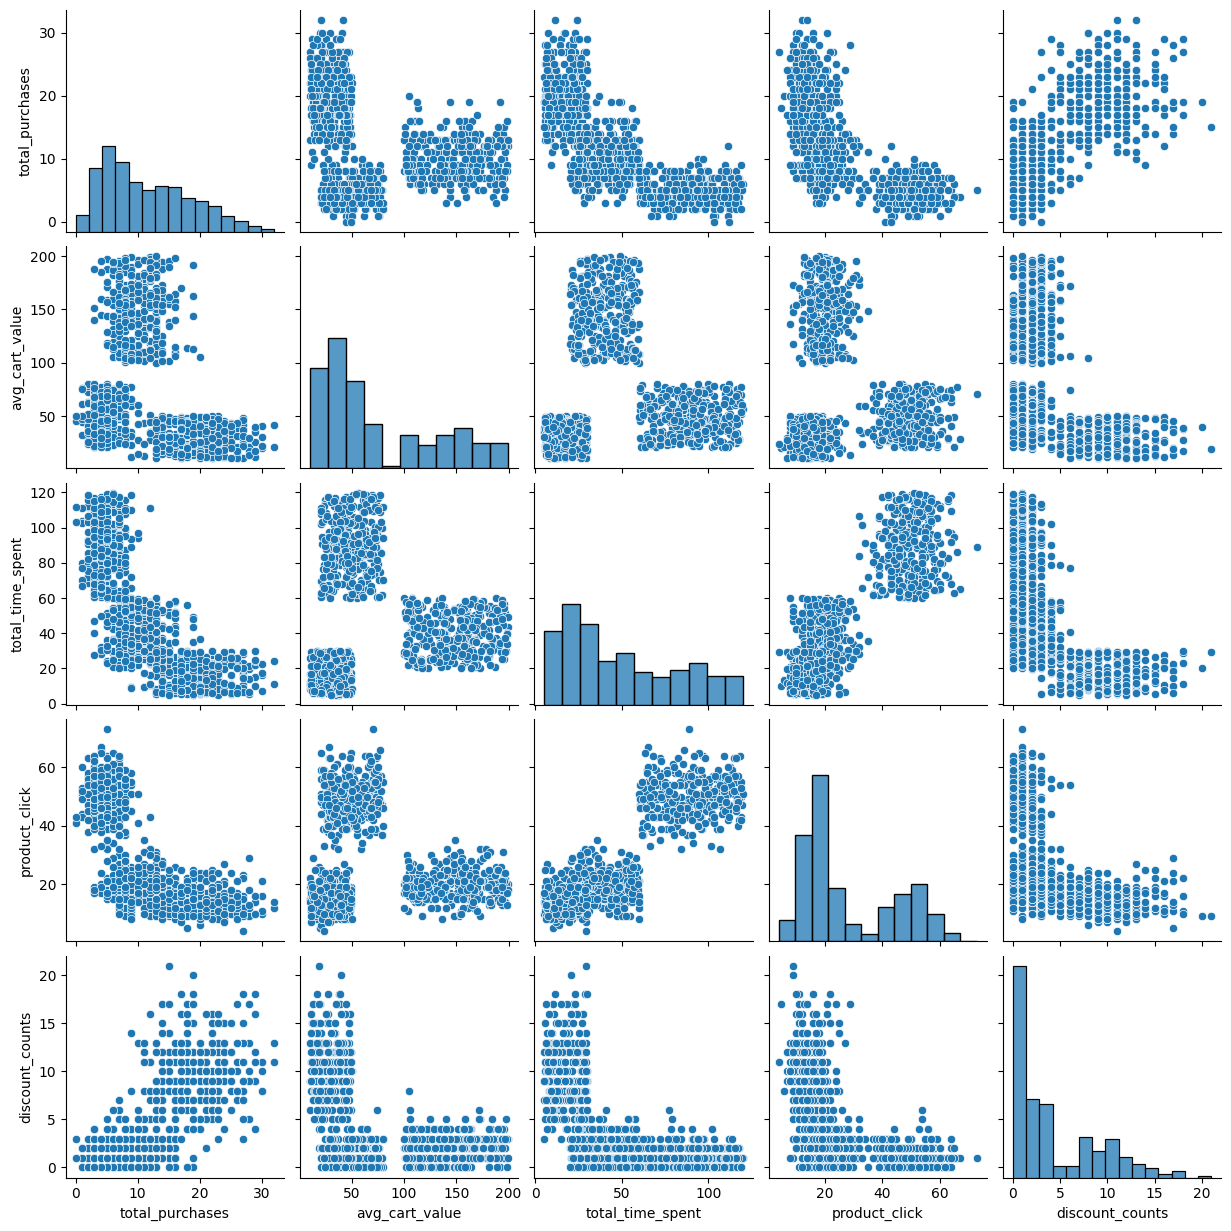

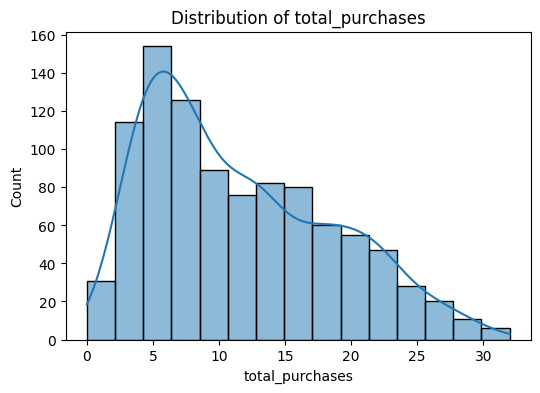

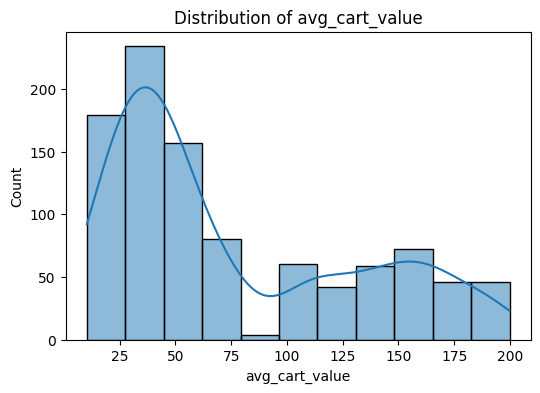

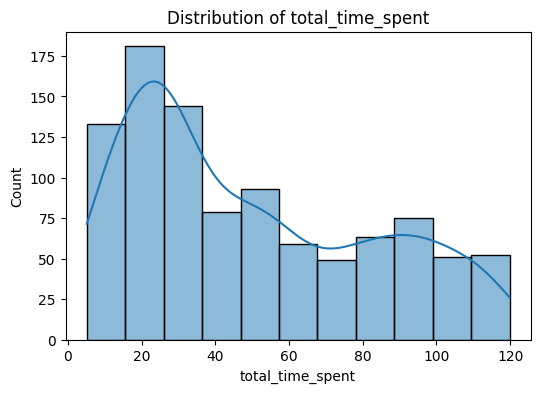

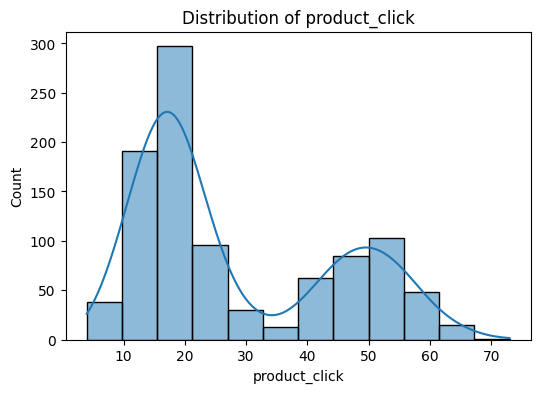

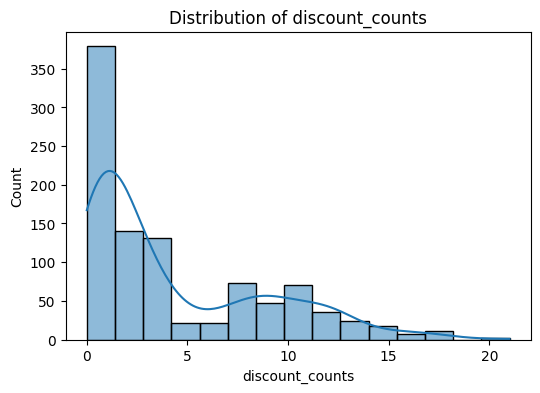

In [43]:
file_path = 'customer_behavior_analytcis.csv'
    
data = load_data(file_path)
show_corr_matrix(data)
plot_pairwise(data)
plot_distributions(data)
clean_data = select_features(data)

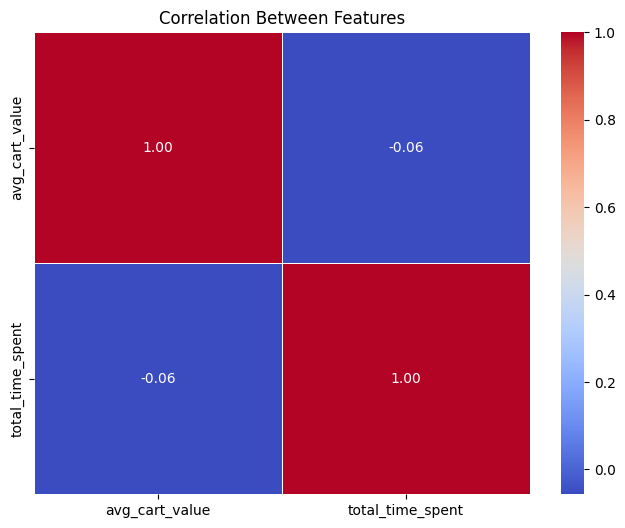

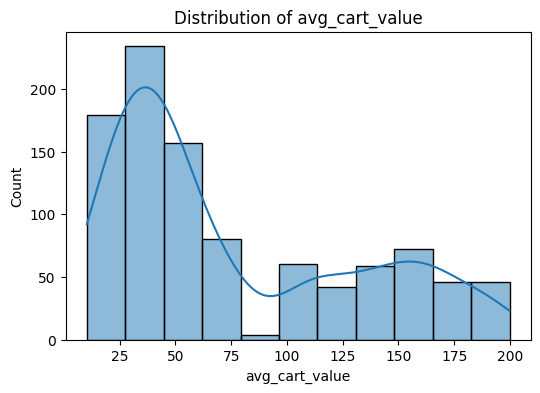

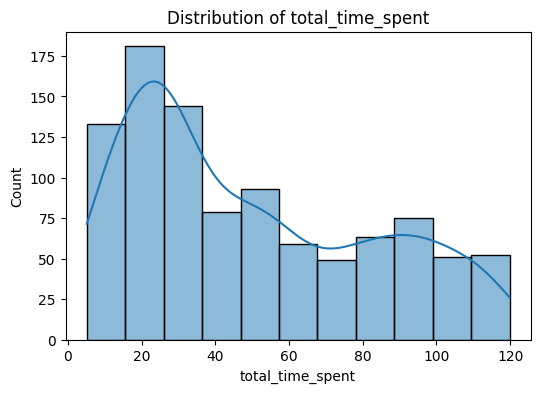

In [40]:

# EDA
show_corr_matrix(clean_data)
plot_distributions(clean_data)


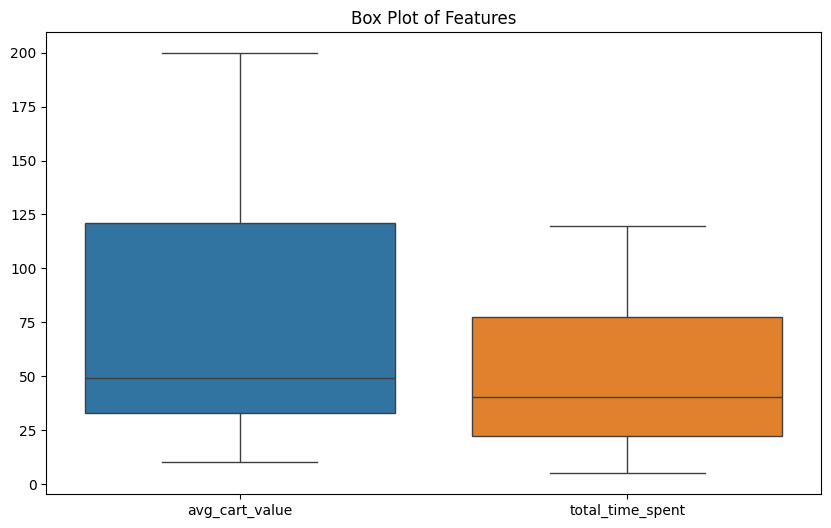

In [41]:
plot_box_plots(clean_data)


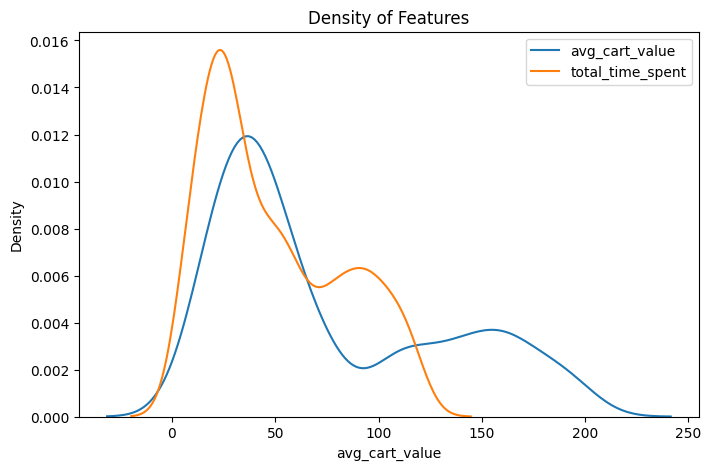

In [42]:
plot_kde(clean_data)


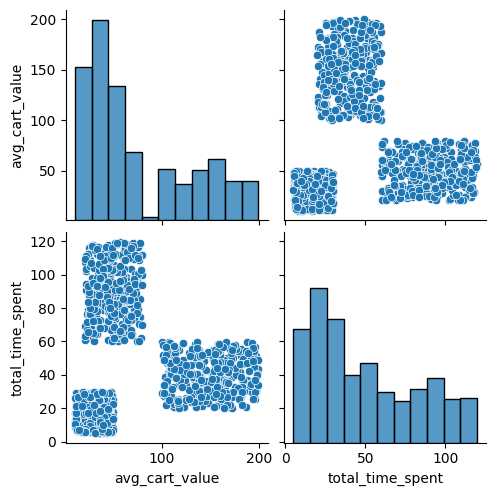

In [21]:
plot_pairwise(clean_data)



Skewness:
 avg_cart_value      0.787570
total_time_spent    0.561091
dtype: float64

Kurtosis:
 avg_cart_value     -0.799998
total_time_spent   -0.953402
dtype: float64


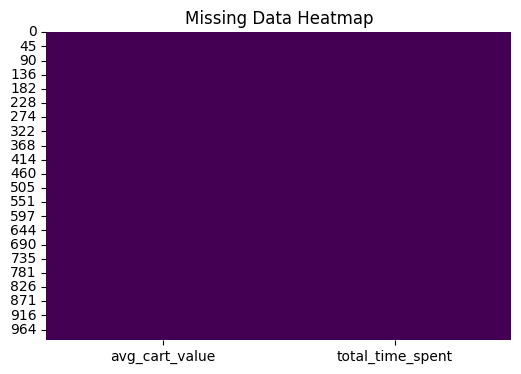

In [22]:
check_skew_kurt(clean_data)
plot_missing(clean_data)

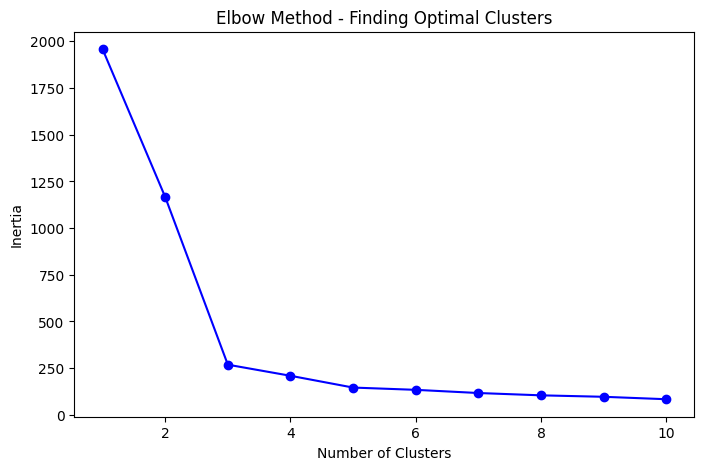

In [102]:
# Scale data
scaled_data = scale_data(clean_data)

# Find best number of clusters using Elbow method
find_best_clusters(scaled_data)

In [103]:
# Compare models (KMeans vs GMM)
compare_clustering(scaled_data)


Model               Silhouette     CH Index       DBI
--------------------------------------------------
KMeans              0.695          3071.641       0.443
GMM                 0.695          3071.641       0.443


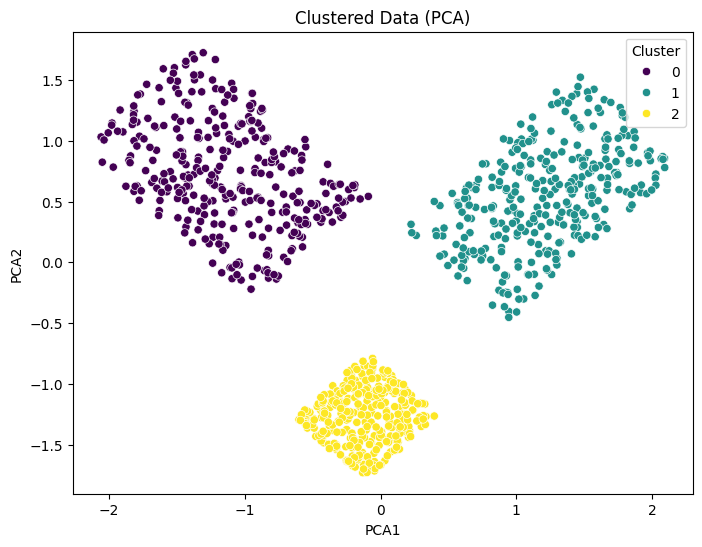

In [104]:
# Create clusters using KMeans
kmeans, clusters = make_clusters(clean_data, scaled_data, num_clusters=3)

In [105]:

# Label clusters based on behavior
label_clusters(clean_data)

                 avg_cart_value  total_time_spent  Cluster      PCA1      PCA2
Segment                                                                       
Bargain Hunters       30.399509         17.453988      2.0 -0.109975 -1.267727
High Spenders        147.327169         40.284369      0.0 -1.119524  0.727114
Window Shoppers       49.029848         90.114726      1.0  1.218589  0.539533


In [106]:
# Evaluate clustering
evaluate_clusters(scaled_data, clusters, kmeans)

Silhouette Score: 0.695
Davies-Bouldin Index: 0.443
RMSE: 0.524
